# Test significance of S1, S2, D1, D2
The idea is to follow the procedure of the paper "Assessing harmfulness and vulnerability in global bipartite networks of
terrorist-target relationships" A. Spelta et al.

In [1]:
import sys

sys.path.insert(0, "../")

import networkx as nx
import numpy as np
import pandas as pd
from scripts.hid_haus import hid_hous
from scripts.get_graph import get_graph

## Get Adjacency matrix and graph

In [2]:
# Get the adjacency matrix from the data
adjacency_matrix = pd.read_csv("../../dataset/large_adjacency_matrix.csv").values

adjacency_matrix = adjacency_matrix[:, :-1]
# Remove the last column of the adjacency matrix
adjacency_matrix = adjacency_matrix[:, :-1]
graph = get_graph(adjacency_matrix)

## Null Model Construction (Level-1)


In [3]:
# Define a function to generate random graphs while preserving degrees
def generate_null_model(bipartite_graph):
    # Get the degree sequences for both bipartite sets
    top_nodes, bottom_nodes = nx.bipartite.sets(bipartite_graph)
    
    top_degrees = bipartite_graph.degree(top_nodes)
    top_degrees = [degree for _, degree in top_degrees]
    
    bottom_degrees = bipartite_graph.degree(bottom_nodes)
    bottom_degrees = [degree for _, degree in bottom_degrees]

    # Create configuration model
    config_model = nx.bipartite.configuration_model(top_degrees, bottom_degrees)
    return nx.Graph(config_model)


# Create an ensemble of random networks
num_null_models = 1001  # You can adjust this number
null_models = [generate_null_model(graph) for _ in range(num_null_models)]

## Statistical Validation:


In [ ]:
# Compute the same measures for each null model
null_model_measures = [hid_hous(nx.adjacency_matrix(null_model), 3) for null_model in null_models]


# Calculate Z-scores for statistical significance
def calculate_z_score(real_value, null_model_values):
    mean_null = np.mean(null_model_values)
    std_null = np.std(null_model_values)
    z_score = (real_value - mean_null) / std_null
    return z_score

[real_kd, real_ks] = hid_hous(adjacency_matrix, 2)

# Compute Z-scores for your measures
z_score_kd = calculate_z_score(real_kd, [kd for kd, _ in null_model_measures])
z_score_ks = calculate_z_score(real_ks, [ks for _, ks in null_model_measures])


## Visualize the z-score

### Create a dataframe containing all metrics

In [7]:
patients = pd.read_csv("../../dataset/large_dataset.csv")

disease = patients["diseases"].unique()
disease_df = pd.DataFrame(disease, columns=["Disease"])
disease_df["L1 Z-score"] = z_score_kd[:, 0].tolist()
disease_df["L2 Z-score"] = z_score_kd[:, 1].tolist()


symptoms = pd.read_csv("../../dataset/Symptom-severity.csv")
symptoms = symptoms["Symptom"].unique()
mask = symptoms != "prognosis"
symptoms = symptoms[mask]

symptoms_df = pd.DataFrame(symptoms, columns=["Symptom"])
symptoms_df["L1 Z-score"] = z_score_ks[:, 0].tolist()
symptoms_df["L2 Z-score"] = z_score_ks[:, 1].tolist()

### L1

<Axes: title={'center': 'Z-score of L1 for Symptoms'}, xlabel='Symptom', ylabel='Z-score'>

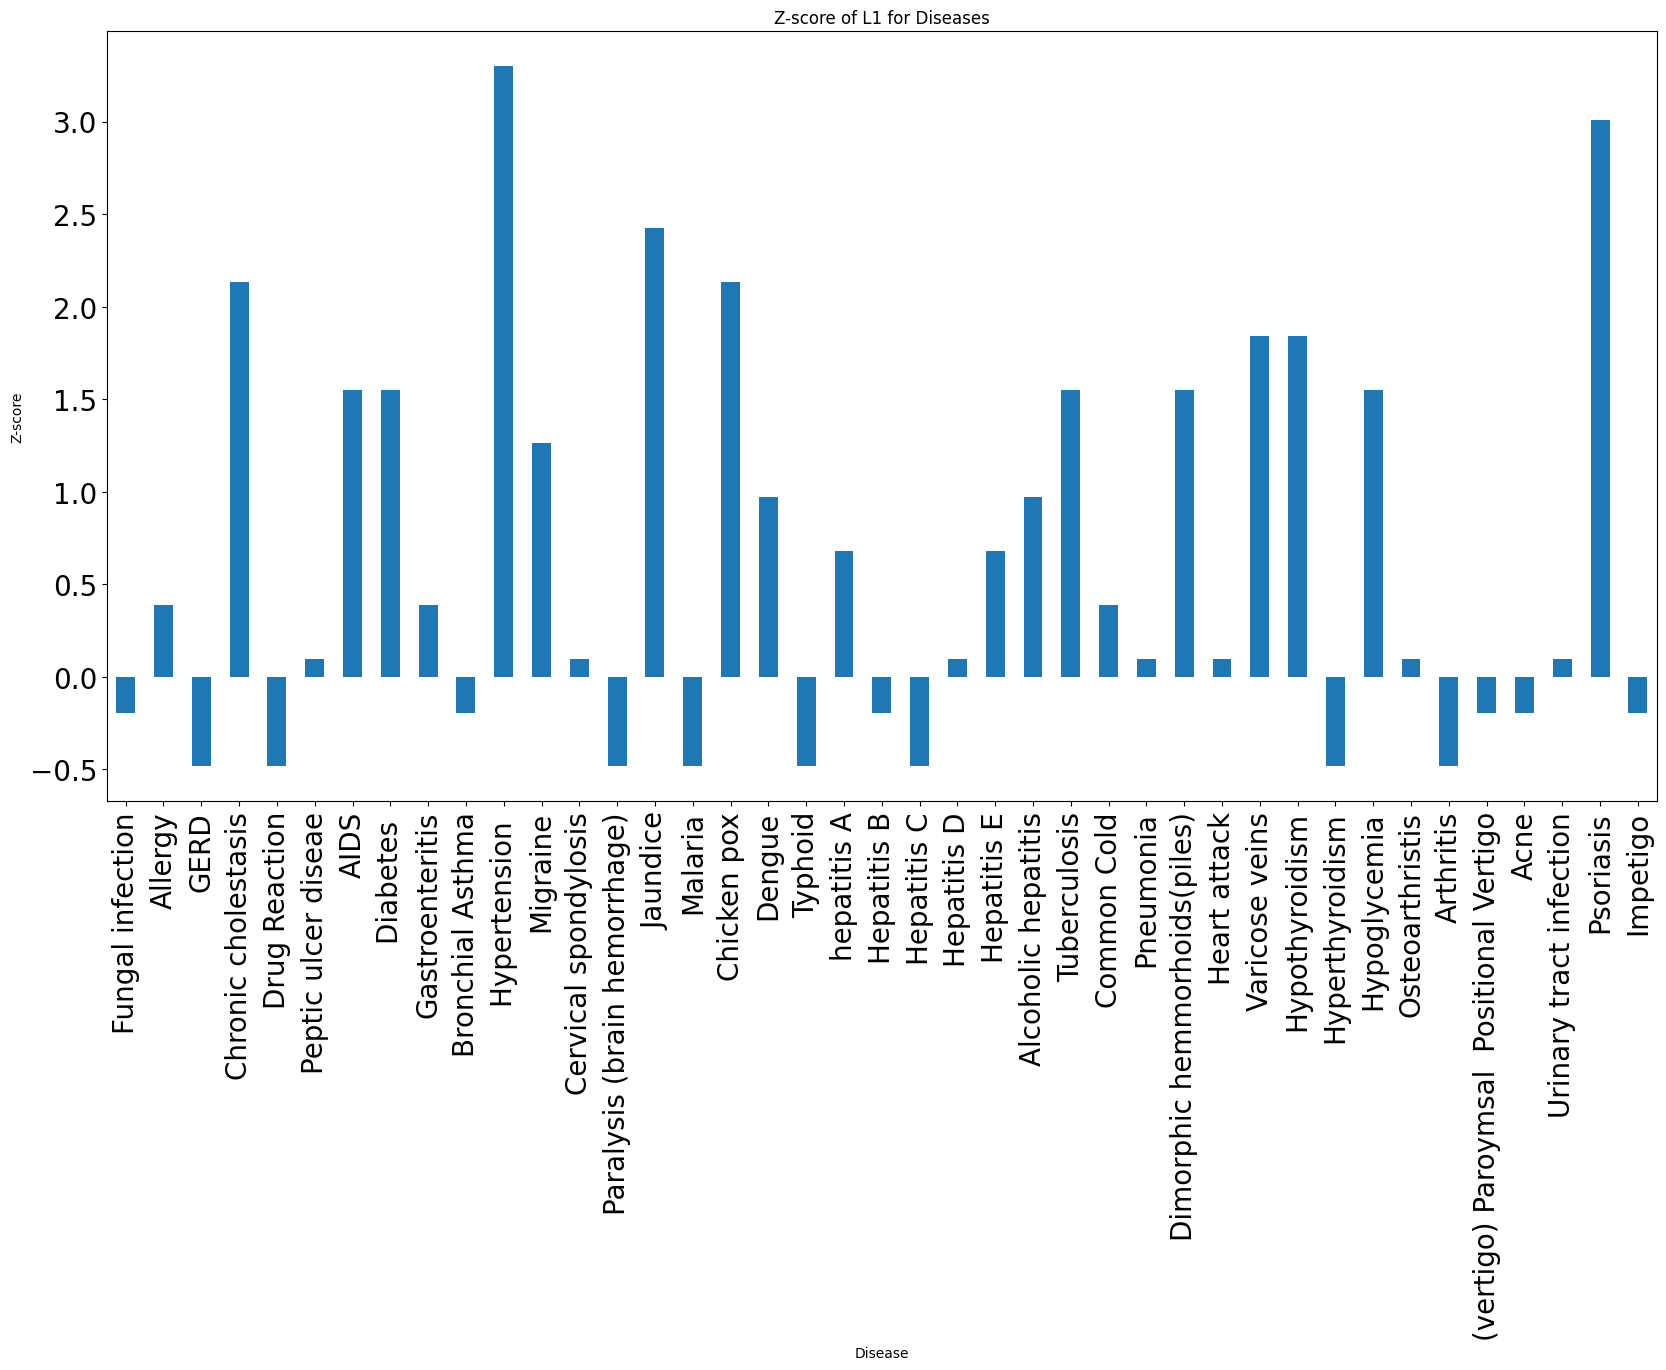

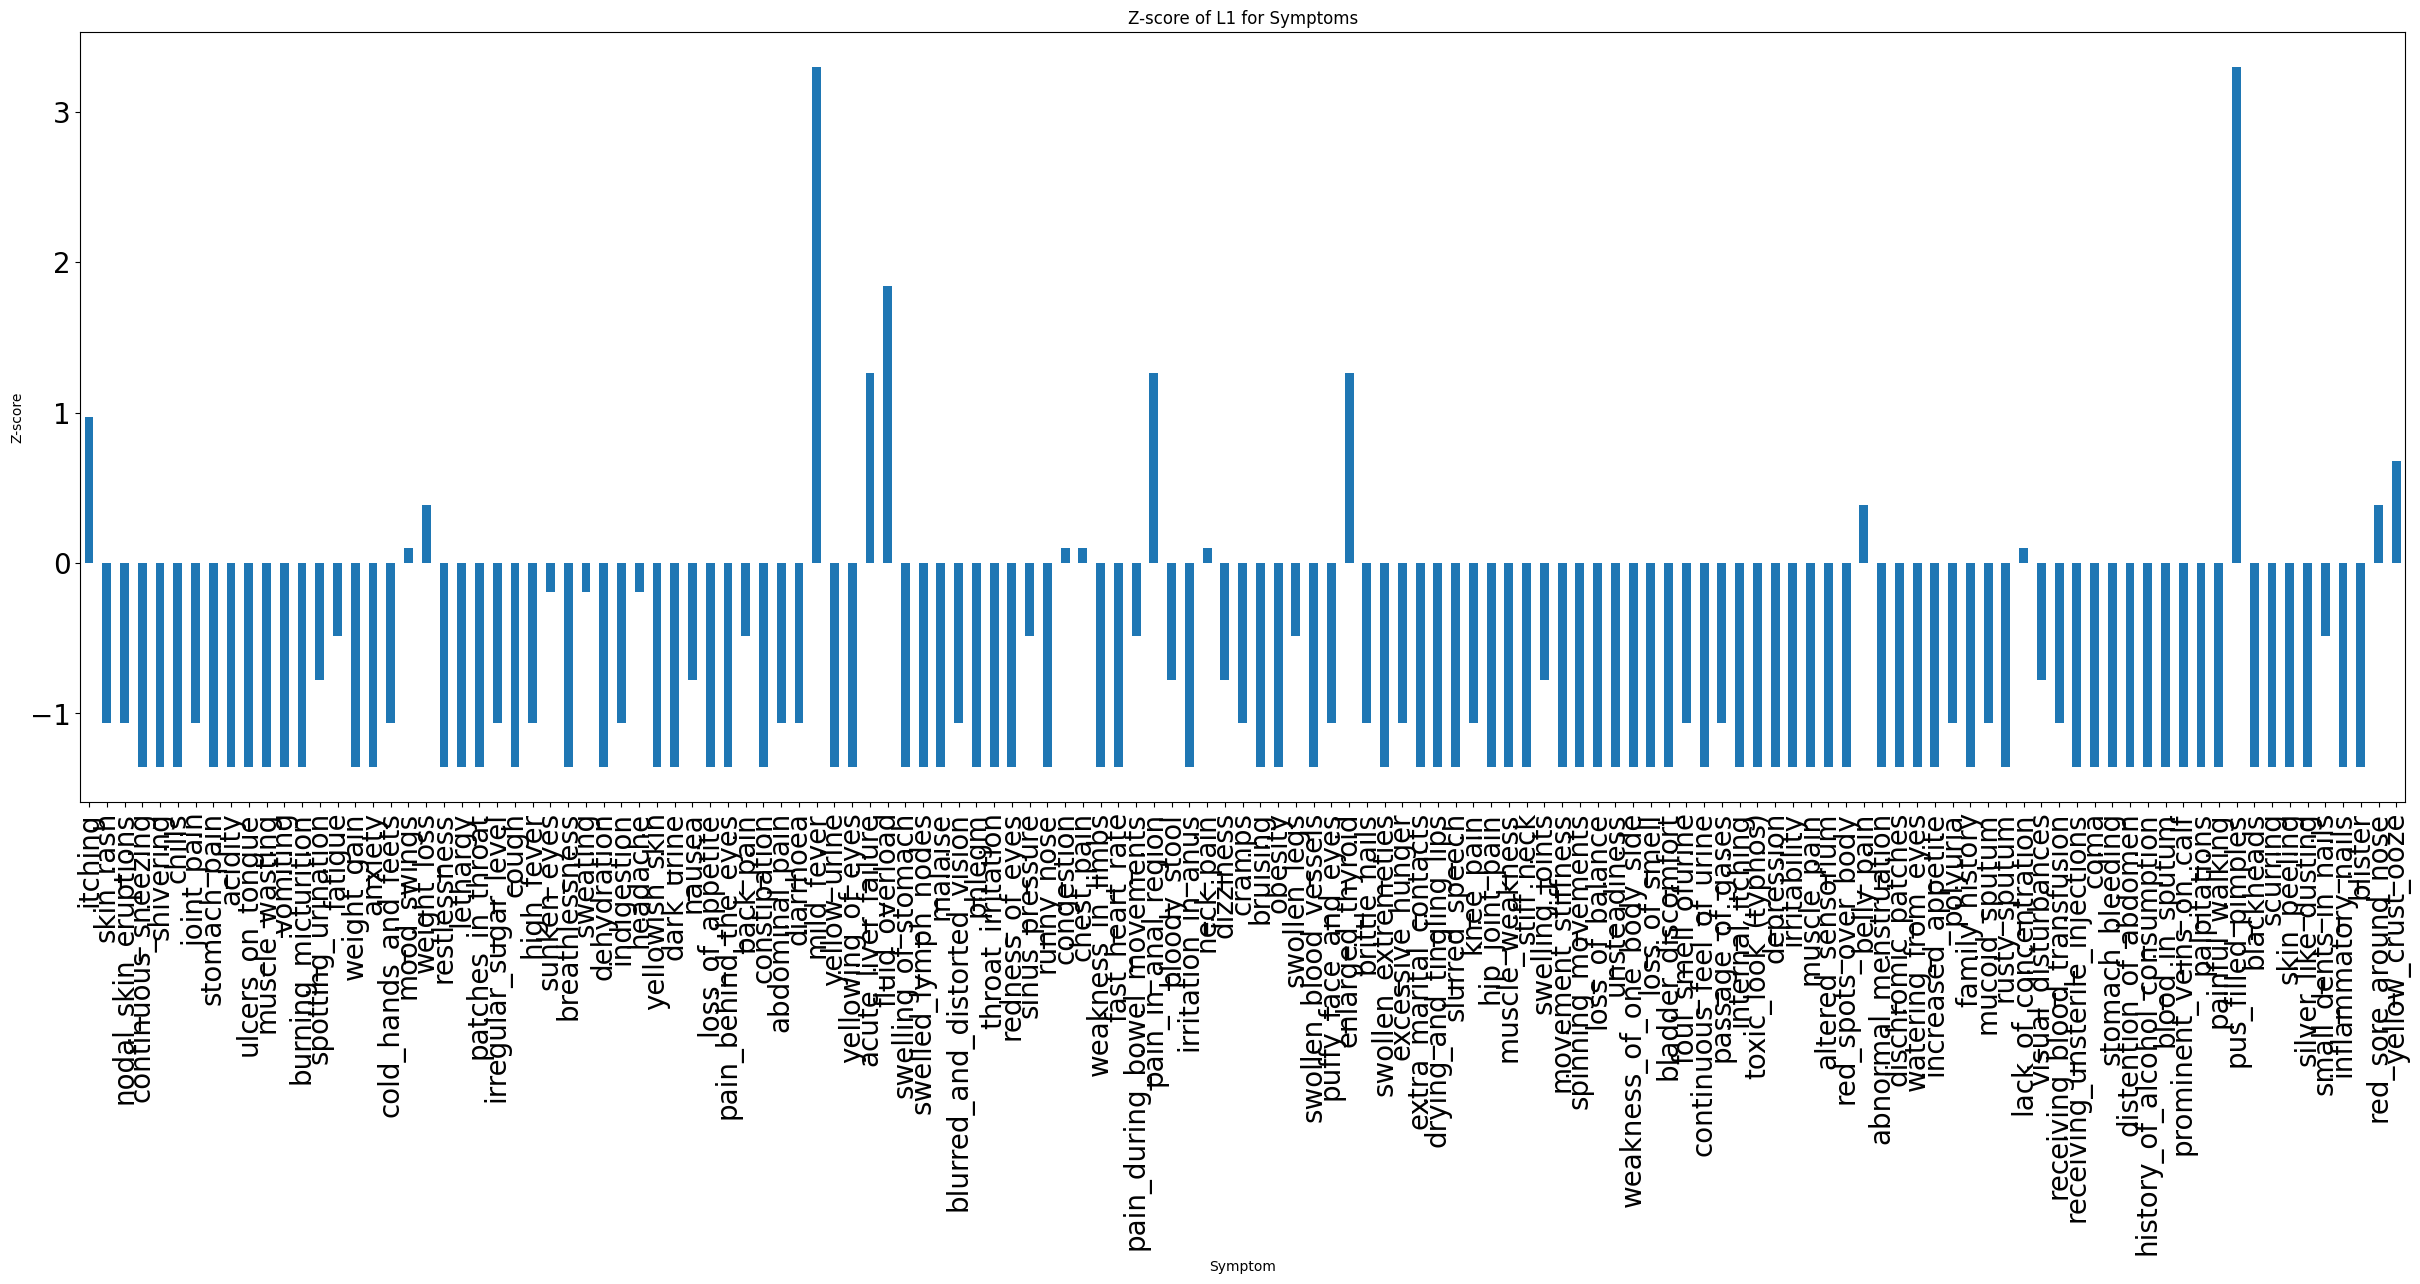

In [8]:
disease_df.plot.bar(
    x="Disease",
    y=["L1 Z-score"],
    rot=90,
    figsize=(20, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L1 for Diseases",
    fontsize=20,
    
)


symptoms_df.plot.bar(
    x="Symptom",
    y=["L1 Z-score"],
    rot=90,
    figsize=(30, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L1 for Symptoms",
    fontsize=20,
)

### L2

<Axes: title={'center': 'Z-score of L2 for Symptoms'}, xlabel='Symptom', ylabel='Z-score'>

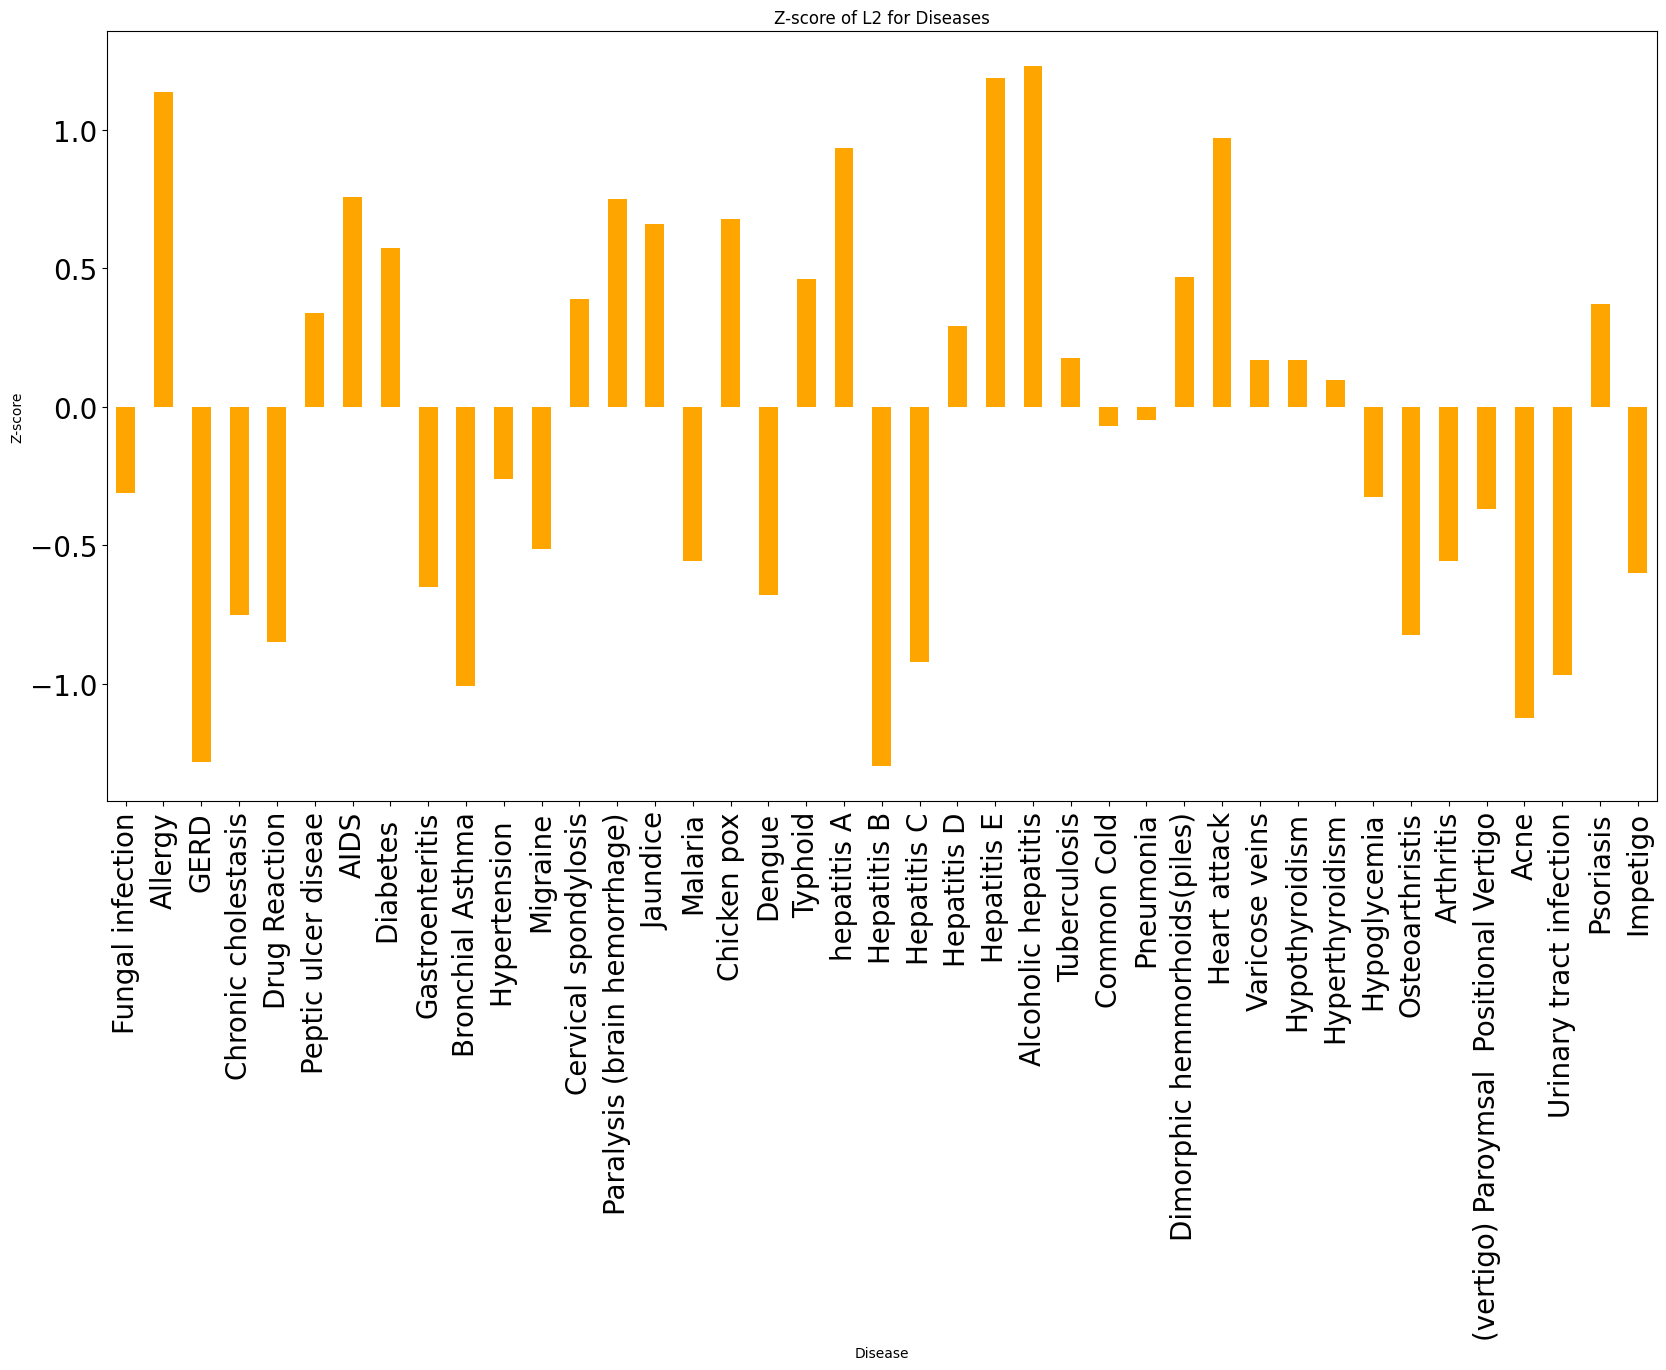

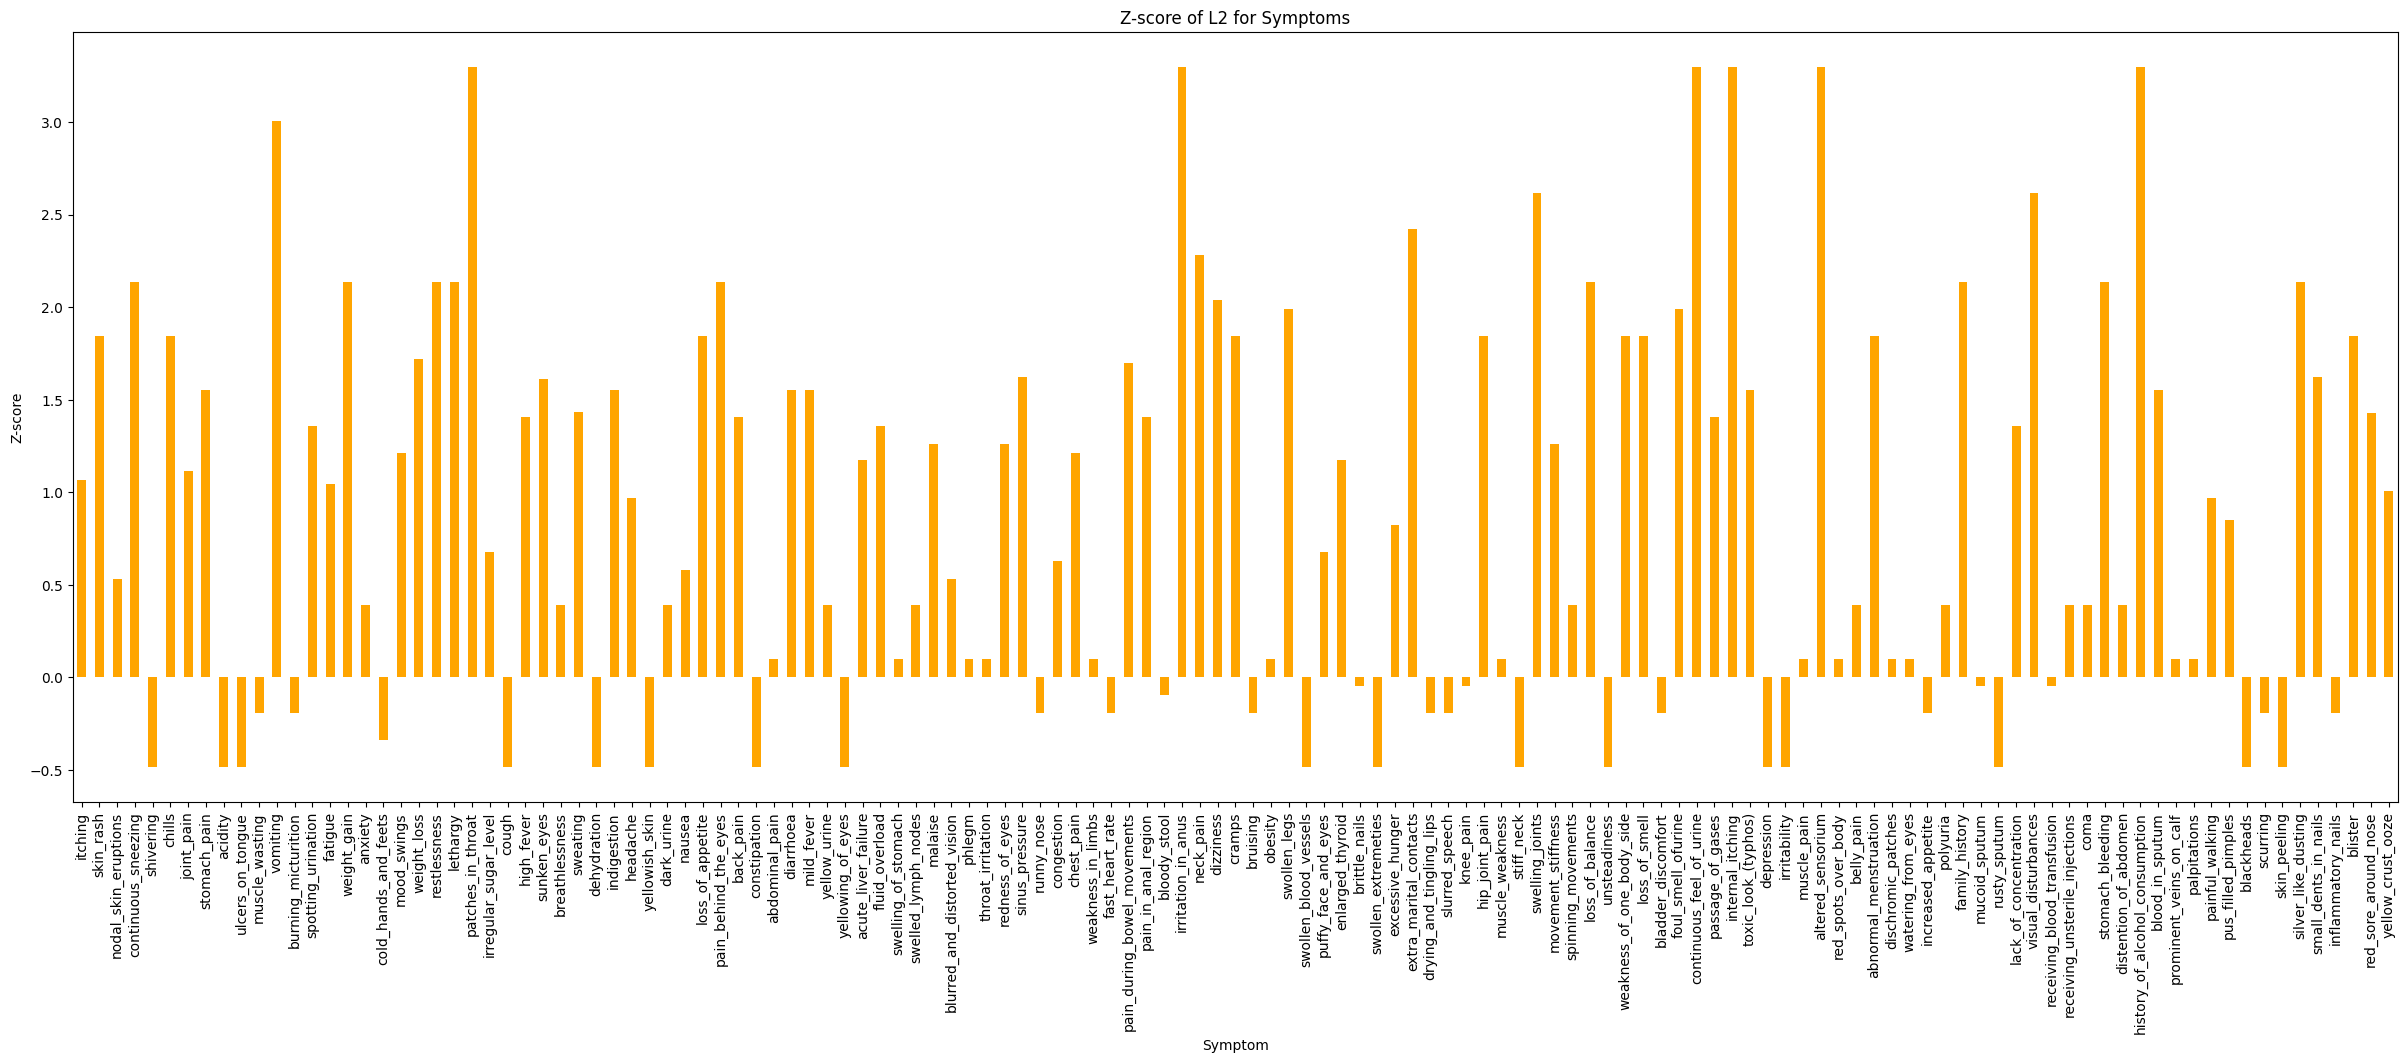

In [9]:
disease_df.plot.bar(
    x="Disease",
    y=["L2 Z-score"],
    rot=90,
    figsize=(20, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L2 for Diseases",
    fontsize=20,
    color="orange"
    
)


symptoms_df.plot.bar(
    x="Symptom",
    y=["L2 Z-score"],
    rot=90,
    figsize=(30, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L2 for Symptoms",
    color="orange"
)